# Analysis of the Harmonic Series in Trumpet Notes

In music school we are taught that each note we play on an instrument not only sounds the fundamental frequency of that note, but also an entire series of overtones which contribute to how the note sounds. This is one component of the answer to the question "Why does a violin sound different from a trumpet if they are playing the same pitch?". In this report, we will examine and analyze the harmonic series in a single trumpet note. The purpose of this report is entirely educational, it gives me (a data scientist) the opportunity to practice using Fourier Transform and better understand the basics of signal processing. There are, however, a wide range of practical use cases for doing this type of analysis which I will mention throughout the report.


This report will focus on three distinct areas:
1. Frequency decomposition of a single trumpet note.
2. Removal of frequencies in the trumpet note to understand the audio effect.
3. Building synthetic trumpet notes using our acquired knowledge.






In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import librosa
import librosa.display
import IPython.display as ipd
import IPython
from scipy.signal import find_peaks
import scipy
import sys

#### Versions
For anyone looking to follow along, here are all the relevant versions. This should allow you to recreate my environment.

In [2]:
print("python: ", sys.version)
print("numpy: ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("librosa: ", librosa.__version__)
print("IPython: ", IPython.__version__)
print("scipy: ", scipy.__version__)

python:  3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
numpy:  2.2.5
matplotlib:  3.10.1
librosa:  0.11.0
IPython:  9.2.0
scipy:  1.15.2


# File Loading and Basic Analysis

Here we use the librosa library and import one of their example audio waveforms. This one is of a trumpet.

In [3]:
librosa.util.list_examples()

AVAILABLE EXAMPLES
--------------------------------------------------------------------
brahms    	Brahms - Hungarian Dance #5
choice    	Admiral Bob - Choice (drum+bass)
fishin    	Karissa Hobbs - Let's Go Fishin'
humpback  	Glacier Bay 60-second clip humpback whale song November 2020
libri1    	Ashiel Mystery - A Detective Story, chapter 2, narrated by Garth Comira
libri2    	The Age of Chivalry / Chapter 18: Perceval / Read by Anders Lankford
libri3    	Sense and Sensibility / Chapter 18 / Jane Austen / Read by Heather Barnett
nutcracker	Tchaikovsky - Dance of the Sugar Plum Fairy
pistachio 	The Piano Lady - Pistachio Ice Cream Ragtime
robin     	Bird Whistling, Robin, Single, 13.wav / InspectorJ
sweetwaltz	Setuniman - Sweet Waltz
trumpet   	Mihai Sorohan - Trumpet loop
vibeace   	Kevin MacLeod - Vibe Ace


In [4]:
#load the trumpet clip
filename = librosa.ex('trumpet')
y, sr = librosa.load(filename)

You can listen to the trumpet clip by just pressing the play button!

In [5]:
ipd.Audio(filename)

Let's plot the waveform of the audio clip. We will do this more than just once so we will define a function to create the plot for us.

In [6]:
def plot_waveform(signal: np.ndarray, sample_rate: float) -> tuple:
    """
    Plots an audio waveform with time on the x-axis.

    Parameters
    ----------
    signal : np.ndarray
        The input audio signal
    sample_rate : float
        The sampling rate of the signal in Hz

    Returns
    -------
    tuple
        (fig, ax) - Matplotlib figure and axis objects for further customization

    Example
    -------
    >>> fig, ax = plot_waveform(y, sr)
    >>> plt.show()
    """
    # Create time array
    duration = len(signal) / sample_rate
    time = np.linspace(0, duration, len(signal))
    
    # Create plot
    fig, ax = plt.subplots(figsize=(12, 4))
    
    # Plot waveform
    ax.plot(time, signal, 'b-', linewidth=0.5)
    
    # Customize plot
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Amplitude')
    ax.set_title('Audio Waveform')
    ax.grid(True)
    
    # Set y-axis limits with some padding
    max_amp = np.max(np.abs(signal))
    ax.set_ylim(-max_amp*1.1, max_amp*1.1)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig, ax

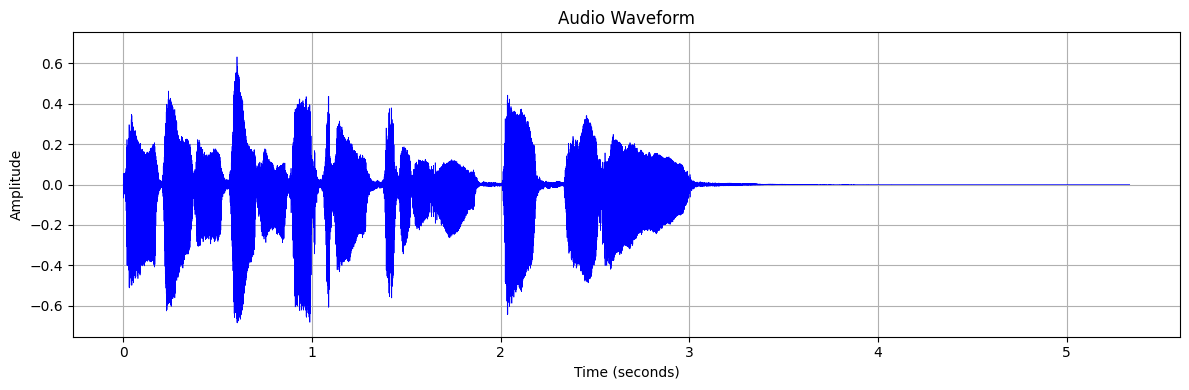

In [7]:
fig, ax = plot_waveform(y, sr)

We are primarily interested in doing a more micro analysis of a single trumpet note so we will crop the data to get only the very first note.

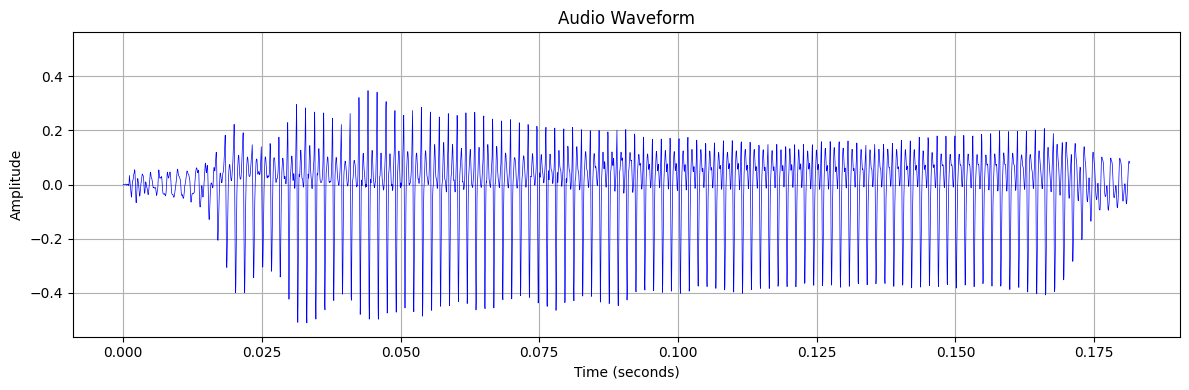

In [8]:
signal = y[0:4000]
fig, ax = plot_waveform(signal, sr)

Now we can listen to it to make sure that we only got the first note and nothing else. If we got more then just the first note then we may have undesired frequencies in our analysis.

In [9]:
ipd.Audio(data=signal, rate=sr)

# Frequency Decomposition with Fourier Analysis

We want to examine the different frequencies that we have as a part of our single trumpet note. The best way to do this is a Fourier Transform. Fourier Transform is one of the essential tools used for signal analysis. It is able to decompose a signal into all the frequencies that make it up. We will use it for our analysis, however, we don't go into detail about how it actually works. If you would like to gain an intuitive understanding about how it works I suggest this video: https://www.youtube.com/watch?v=spUNpyF58BY



# Harmonic Series

Now would also be a good time to give a little bit of background on the harmonic series. The harmonic series in *math* is defined as the infinite series formed by summing all positive unit fractions.

$$\sum_{n=1}^{\infty} \frac{1}{n} = 1 + \frac{1}{2} + \frac{1}{3} + \frac{1}{4} + \cdots$$

The harmonic series in *music* is generally referred to as the sequence of integer multiples of some fundamental frequency where the fundamental is the perceived note. For example, if an instrument plays the note A you would hear the frequency of 440hz. However, baked into that note are also the pitches 440x2=880, 440x3=1320, 440x4=1760, etc...  These extra frequencies are part of what gives a particular note it's "sound". This is one of the fundamental things that gives each instrument it's own sound.

Here we will define a helper function to perform the Fourier Transform and the plot the resulting frequency vs magnitude result. This will show us what the prominent frequencies in any signal are.

In [10]:
def plot_frequency_spectrum(signal: np.ndarray, sample_rate: float, return_peaks: bool = False) -> tuple:
    """
    Analyzes and plots the frequency spectrum of an audio signal with peak detection
    and musical note labeling. Optionally returns the list of peak frequencies.

    Parameters
    ----------
    signal : np.ndarray
        The input audio signal
    sample_rate : float
        The sampling rate of the signal in Hz
    return_peaks : bool, optional
        If True, returns the list of peak frequencies along with the plot

    Returns
    -------
    tuple
        (fig, ax) - Matplotlib figure and axis objects for further customization
        If return_peaks is True, also returns a list of peak frequencies

    Example
    -------
    >>> fig, ax = plot_frequency_spectrum(y, sr)
    >>> plt.show()
    >>> fig, ax, peaks = plot_frequency_spectrum(y, sr, return_peaks=True)
    """
    # Compute FFT
    n = len(signal)
    fft_result = np.fft.fft(signal)
    frequencies = np.fft.fftfreq(n, d=1/sample_rate)
    
    # Get positive frequencies
    positive_frequencies = frequencies[:n//2]
    magnitude_spectrum = np.abs(fft_result[:n//2])

    # Find peaks with hard-coded parameters
    peaks, _ = find_peaks(magnitude_spectrum, height= 2, distance=100)
    peaks_frequency = positive_frequencies[peaks]
    peaks_magnitude = magnitude_spectrum[peaks]

    # Create plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot magnitude spectrum
    ax.plot(positive_frequencies, magnitude_spectrum, marker='.')
    
    # Plot peaks
    ax.plot(peaks_frequency, peaks_magnitude, 
            marker='x', color='red', linestyle='none')

    # Add note labels for each peak
    for freq, mag in zip(peaks_frequency, peaks_magnitude):
        note = librosa.hz_to_note(freq)
        ax.annotate(f'{note}={freq:.0f}Hz', 
                   xy=(freq, mag),  # Point to label
                   xytext=(freq-1000, mag+2),  # Text position
                   )

    max_idx = np.argmax(magnitude_spectrum)
    max_freq = positive_frequencies[max_idx]
    fundemental_note = librosa.hz_to_note(max_freq)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Magnitude")
    ax.set_title(f"Frequency Spectrum of trumpet note")
    ax.grid(True)

    # Adjust layout to prevent label clipping
    plt.tight_layout()

    if return_peaks:
        return fig, ax, peaks_frequency.tolist()
    else:
        return fig, ax

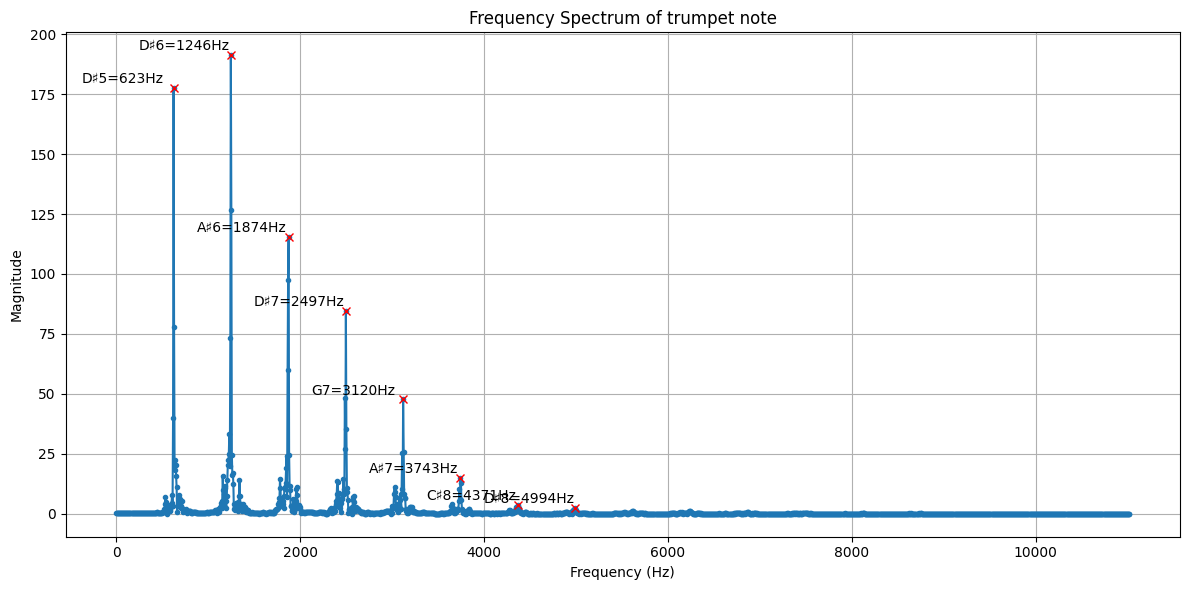

In [11]:
fig, ax, peak_frequencies = plot_frequency_spectrum(signal, sr, return_peaks=True)

We can see that the resulting trumpet note is a D#(Eb). The fundamental (the note we hear) is Eb5, however, you can see very clearly in the plot we also have the frequencies D#6(Eb6), A#6(Bb6), D#7(Eb7), G7, A#7(Bb7), and C#8(Db8). After that it get's a bit more murky because the magnitudes get very small.

This plot makes the hamonic series very aparent. Let's take the fundamental and multiply it by integers to really drive the point home.

| Note | Frequency | Integer Multiple |
|----------|----------|----------|
| Eb    | 623     | x1     |
| Eb    | 1246     | x2     |
| Bb   | 1874     | x3     |
| Eb    | 2497     | x4     |
| G    | 3120     | x5     |
| Bb    | 3743     | x6     |
| Db    | 4371     | x7     |

### Signal manipulation

Now that we know this, we will see that the note sounds like if we deconstruct it's components. Mainly, we are interested in the contribution of the fundamental frequency vs all the harmonic overtones. Even though the fundamental is the pitch our ears hear, how much does it actually matter in the sound composition of the note?

We will perform two exercies to figure this out. First we will remove all the frequencies except the fundamental. Second, we will remove only the fundamental. Then we can listen to the audio of both and see what matters more in terms of audio quality of the note.

In order to do this, we will make three helper functions
1. **reconstruct_frequency()** will take all the information needed to construct a cosine wave.
2. **get_frequency_amplitude()** will use the Fourier Transform data and calculate the amplitude of the target frequency. This is done using the equation $amplitude = \frac{2}{N} * magnitude$. The magnitude is what is plotted above in the Fourier Transform plot. N is the length of the signal. The reason we multiply by 2 is because we are only looking positive frequencies, while the Fourier Transform natively produces both positive and negative frequencies. We divide by N in order to normalize the amplitude to the length of the signal.
3. **get_frequency_phase()** will use the Fourier Transform data and calculate the phase of the target frequency. This can be done by using the angle function in numpy which natively takes in the complex number from the Fourier Transform.

In [12]:
def reconstruct_frequency(frequency: float, 
                        time: np.ndarray, 
                        amplitude: float, 
                        phase: float) -> np.ndarray:
    """
    Reconstructs a sinusoidal signal with specified frequency, amplitude, and phase.

    Parameters
    ----------
    frequency : float
        The frequency of the sinusoid in Hz.
    time : np.ndarray
        Time array in seconds.
    amplitude : float
        The amplitude of the sinusoid.
    phase : float
        The phase offset in radians.

    Returns
    -------
    np.ndarray
        The reconstructed sinusoidal signal.
    """
    return amplitude * np.cos(2 * np.pi * frequency * time + phase)

In [13]:
def get_frequency_amplitude(signal: np.ndarray, sample_rate: float, target_freq: float) -> float:
    """
    Finds the amplitude of a signal at a specific frequency.

    Parameters
    ----------
    signal : np.ndarray
        The input signal to analyze.
    sample_rate : float
        The sampling rate of the signal in Hz.
    target_freq : float
        The frequency to analyze in Hz.

    Returns
    -------
    float
        The amplitude of the signal at the target frequency.

    Raises
    ------
    ValueError
        If the target frequency is higher than the Nyquist frequency.
        If the signal is empty or the sample rate is invalid.
    """
    # Input validation
    if not isinstance(signal, np.ndarray):
        signal = np.array(signal)
    
    if len(signal) == 0:
        raise ValueError("Signal cannot be empty")
    
    if sample_rate <= 0:
        raise ValueError("Sample rate must be positive")
    
    nyquist = sample_rate / 2
    if target_freq >= nyquist:
        raise ValueError(f"Target frequency ({target_freq} Hz) must be less than "
                       f"Nyquist frequency ({nyquist} Hz)")

    # Compute FFT
    N = len(signal)
    Y = np.fft.fft(signal)
    freqs = np.fft.fftfreq(N, 1/sample_rate)

    # Find the index of the target frequency
    freq_idx = np.argmin(np.abs(freqs - target_freq))
    
    # Get amplitude at target frequency
    amplitude = 2.0/N * np.abs(Y[freq_idx])
    
    return amplitude

In [14]:
def get_frequency_phase(signal: np.ndarray, sample_rate: float, target_freq: float) -> float:
    """
    Finds the phase of a signal at a specific frequency.

    Parameters
    ----------
    signal : np.ndarray
        The input signal to analyze.
    sample_rate : float
        The sampling rate of the signal in Hz.
    target_freq : float
        The frequency to analyze in Hz.

    Returns
    -------
    float
        The phase of the signal at the target frequency in radians.

    Raises
    ------
    ValueError
        If the target frequency is higher than the Nyquist frequency.
        If the signal is empty or the sample rate is invalid.
    """
    # Input validation
    if not isinstance(signal, np.ndarray):
        signal = np.array(signal)
    
    if len(signal) == 0:
        raise ValueError("Signal cannot be empty")
    
    if sample_rate <= 0:
        raise ValueError("Sample rate must be positive")
    
    nyquist = sample_rate / 2
    if target_freq >= nyquist:
        raise ValueError(f"Target frequency ({target_freq} Hz) must be less than "
                       f"Nyquist frequency ({nyquist} Hz)")

    # Compute FFT
    N = len(signal)
    Y = np.fft.fft(signal)
    freqs = np.fft.fftfreq(N, 1/sample_rate)

    # Find the index of the target frequency
    freq_idx = np.argmin(np.abs(freqs - target_freq))
    
    # Get phase at target frequency
    phase = np.angle(Y[freq_idx])
    
    return phase

### Remove all frequencies except the fundamental

In order to do this we will iterate and remove all prominent frequencies except for the fundamental down to a certain threshold of magnitude. This threshold is currently set at 2 in the **plot_frequency_spectrum** function. This is necessary because there are many surrounding frequencies for each harmonic that must be removed in order to fully remove the sound of that harmonic.

In [15]:
time_seconds = np.arange(len(signal)) / sr #define the time array in seconds for use later

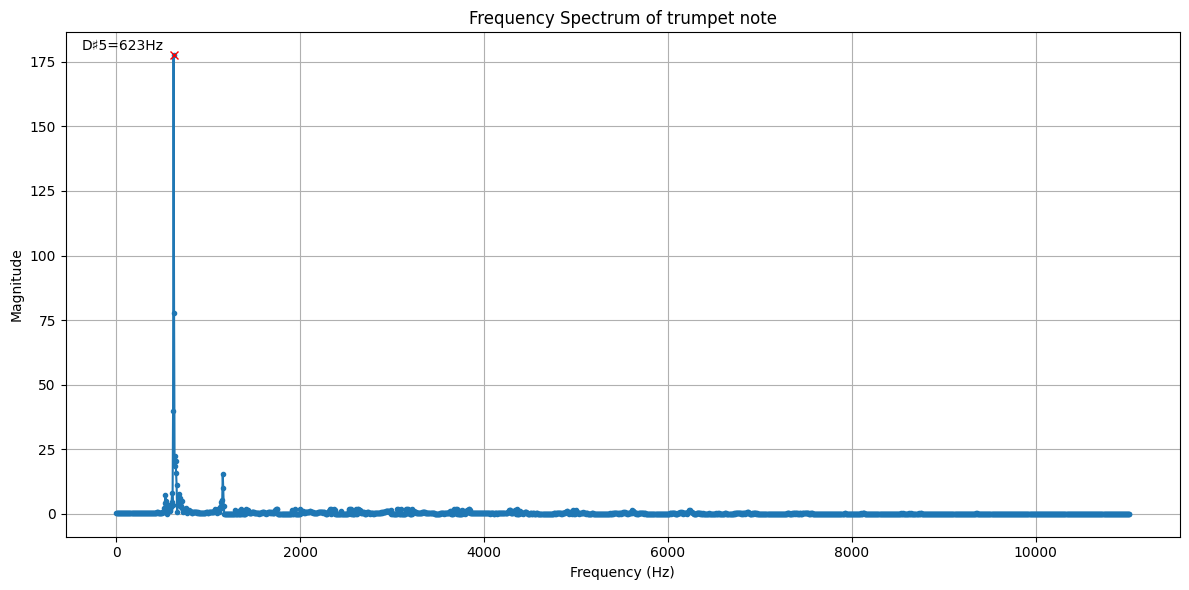

In [16]:
harmonics_removed = signal.copy()
while True:
    fig, ax, peak_frequencies = plot_frequency_spectrum(harmonics_removed, sr, return_peaks=True)
    if len(peak_frequencies) == 1:
        break
    plt.close(fig)  # Close the figure to prevent display (except for the last iteration)
    for freq in peak_frequencies:
        if abs(freq - 622.9125) < 1:
            continue
        amplitude = get_frequency_amplitude(signal, sr, freq)
        phase = get_frequency_phase(signal, sr, freq)
        signal_freq = reconstruct_frequency(freq, time_seconds, amplitude, phase)
        harmonics_removed = harmonics_removed - signal_freq

### Remove only fundamental

This is a similar process to removing all of the harmonics except this time we are removing the fundamental and all surrounding frequencies down to a threshold of 2.

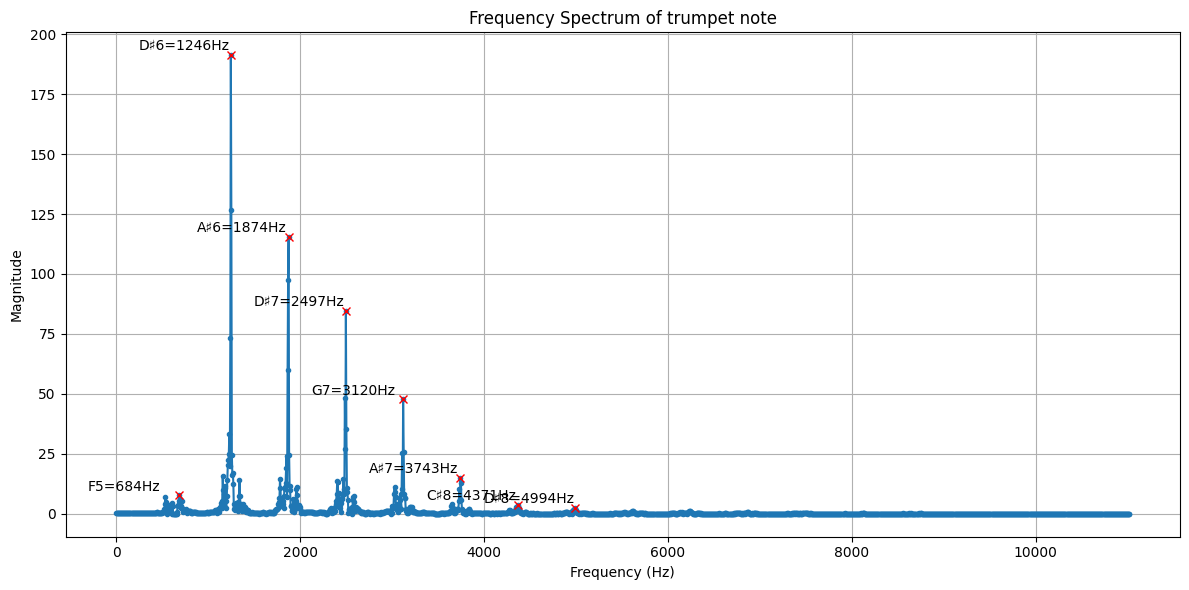

In [17]:
fundamental_removed = signal.copy()
last_peak_frequencies = []
while True:
    fig, ax, peak_frequencies = plot_frequency_spectrum(fundamental_removed, sr, return_peaks=True)
    if last_peak_frequencies == peak_frequencies:
        break
    last_peak_frequencies = peak_frequencies
    plt.close(fig)  # Close the figure to prevent display
    for freq in peak_frequencies:
        if abs(freq - 622.9125) > 50:
            continue
        amplitude = get_frequency_amplitude(signal, sr, freq)
        phase = get_frequency_phase(signal, sr, freq)
        signal_freq = reconstruct_frequency(freq, time_seconds, amplitude, phase)
        fundamental_removed = fundamental_removed - signal_freq

### Comparison of Fundamental vs Harmonics

Now just by listening to these clips we can hear how important the harmonics are to the sound signature of the note. The fundamental can be removed and the note still sounds relatively whole. If the harmonics are removed however leaving only the fundamental, it really doesn't sounds like a trumpet note at all.

In [18]:
ipd.Audio(data=harmonics_removed, rate=sr)

In [19]:
ipd.Audio(data=fundamental_removed, rate=sr)

### Remove Fundamental and Harmonics

Now we will remove both the fundamental and the harmonics. The first reason for doing this is so that we can collect all the important signal data that makes up the trumpet note. The other reason is just for fun to see what the note sounds like if you remove all prominent frequencies.

Note - in the field of signal processing I can image this could be very useful. If you have some signal and you want to clean any potential noise in it, you can deconstruct it into all of it's component frequencies and the filter out frequencies with an amplitude below some threshold. In the audio world this could potentially help do something like remove white noise or static.

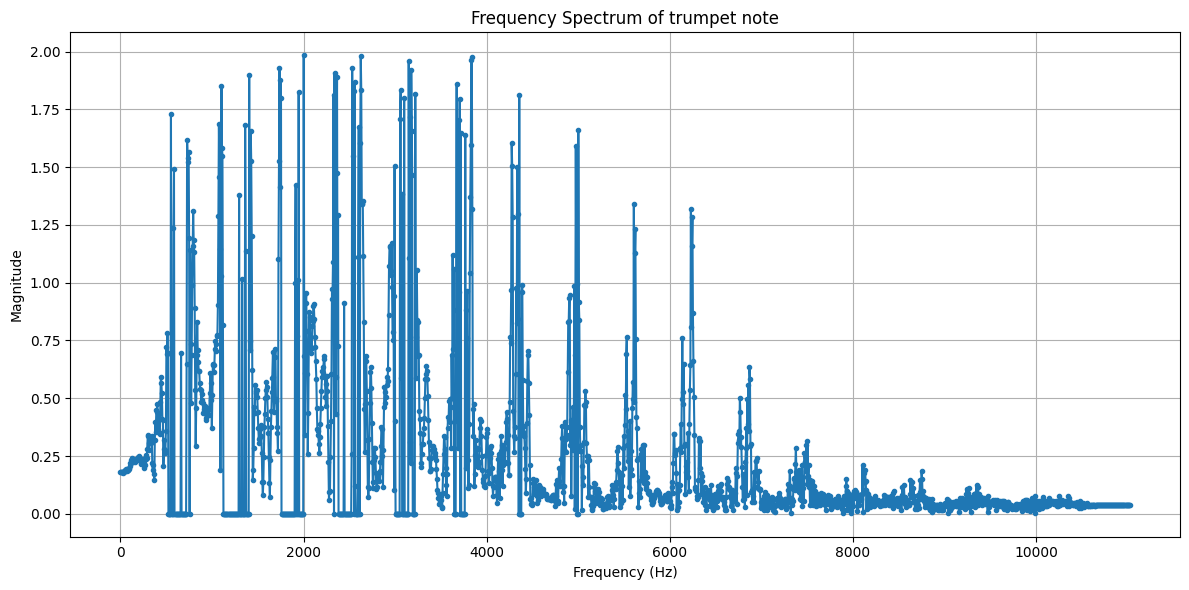

In [20]:
all_signals_removed = signal.copy()
removed_signals = []
removed_frequencies = []
removed_amplitudes = []
removed_phases = []
while True:
    fig, ax, peak_frequencies = plot_frequency_spectrum(all_signals_removed, sr, return_peaks=True)
    if len(peak_frequencies) == 0:
        break
    plt.close(fig)  # Close the figure to prevent display
    for freq in peak_frequencies:
        amplitude = get_frequency_amplitude(signal, sr, freq)
        phase = get_frequency_phase(signal, sr, freq)
        signal_freq = reconstruct_frequency(freq, time_seconds, amplitude, phase)
        removed_signals.append(signal_freq)
        removed_frequencies.append(freq)
        removed_amplitudes.append(amplitude)
        removed_phases.append(phase)
        all_signals_removed = all_signals_removed - signal_freq

It definitely doesn't sound like a trumpet anymore!

In [21]:
ipd.Audio(data=all_signals_removed, rate=sr)

# Pitch shifting the original signal

Now that we have extracted all the signal information we can try some things with it. First, we will just reassemble the signal and make sure it sounds good.


Next, we will define a function which will help us shift the pitch by however many half steps (and whichever direction) we choose. It works based on the principle that to move an octave, you must double or halve your frequency. In 12-tone equal temperament (standard for most music), an octave is divided into 12 equally spaced pitches (semitones). Thus, to move a certain number of semitones, we can use the formula $f' = f \times 2^{n/12}$, where $f$ is the original frequency and $n$ is the number of semitones to shift by.

We can then use that function to create some major scales and see what they sound like.



In [22]:
#convert each list of np.float32 to python float
removed_frequencies = [float(i) for i in removed_frequencies]
removed_amplitudes = [float(i) for i in removed_amplitudes]
removed_phases = [float(i) for i in removed_phases]

In [23]:
summed_signal = np.zeros(len(time_seconds))
for freq, amp, phase in zip(removed_frequencies, removed_amplitudes, removed_phases):
    reconstructed_signal = reconstruct_frequency(freq, time_seconds, amp, phase)
    summed_signal += reconstructed_signal
ipd.Audio(data=summed_signal, rate=sr) #reassembled pitch sounds good!


In [24]:
def shift_pitch(frequency, semitones):
    """
    Shifts the given frequency up or down by a specified number of semitones.

    Parameters:
        frequency (float): The original frequency in Hz.
        semitones (int or float): Number of semitones to shift.
                                  Positive for up, negative for down.

    Returns:
        float: The new frequency, shifted by the given number of semitones.
    """
    semitone_ratio = 2 ** (1/12)
    return frequency * (semitone_ratio ** semitones)

In [25]:
major_scale_down_shifts = [0, -1, -3, -5, -7, -8, -10, -12] #semi-tone shifts for a major scale
scale_notes = []
for shift_amount in major_scale_down_shifts:
    summed_signal = np.zeros(len(time_seconds))
    for freq, amp, phase in zip(removed_frequencies, removed_amplitudes, removed_phases):
        reconstructed_signal = reconstruct_frequency(shift_pitch(freq, shift_amount), time_seconds, amp, phase)
        summed_signal += reconstructed_signal
    scale_notes.extend(list(summed_signal))

ipd.Audio(data=scale_notes, rate=sr)

In [26]:
major_scale_up_shifts = [0, 2, 4, 5, 7, 9, 11, 12] #semi-tone shifts for a major scale
scale_notes = []
for shift_amount in major_scale_up_shifts:
    summed_signal = np.zeros(len(time_seconds))
    for freq, amp, phase in zip(removed_frequencies, removed_amplitudes, removed_phases):
        reconstructed_signal = reconstruct_frequency(shift_pitch(freq, shift_amount), time_seconds, amp, phase)
        summed_signal += reconstructed_signal
    scale_notes.extend(list(summed_signal))

ipd.Audio(data=scale_notes, rate=sr)

You can hear as you get farther away from the recorded pitch, the note stops sounding like a real trumpet. I think there are multiple reasons for this, the main one being that the amplitude of all the smaller frequencies surrounding each of the harmonics most likely would not work for other pitches as it gets farther away from the recorded pitch.

# Simulate the sound of the trumpet

In this section we wil try to simulate the sounds of the trumpet by learning from the recording and applying that to a compltely new and synthetic signal.

## Analysis of recorded frequencies

First we must take a look at the recorded data so we know how to synthetically create our new signal.

In order to do this we need to organize the frequency, phase, and amplitude data into their groupings for each harmonic. We can sort the three lists the same way and then bin the data on some threshold.

Then, for each harmonic, we can look at the standard deviation of the frequencies, amplitudes, and phases. This will help us understand the relationship between the overtone series and all the frequencies that surround each overtone. 

In [27]:
# sort all the frequencies, amplitudes, and phases by frequency and keep the order the same for each list
sorted_freqs = sorted(removed_frequencies)
sorted_amplitudes = sorted(removed_amplitudes, key = lambda amp: removed_frequencies[removed_amplitudes.index(amp)])
sorted_phases = sorted(removed_phases, key = lambda phase: removed_frequencies[removed_phases.index(phase)])

Text(0.5, 1.0, 'Histogram of frequncies for the trumpet note')

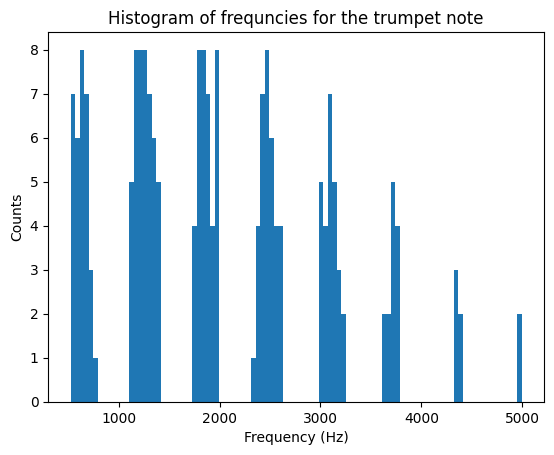

In [28]:
plt.hist(removed_frequencies, bins=100); #it looks like a threshold of a couple hundred hz between each harmonic should work
plt.xlabel("Frequency (Hz)")
plt.ylabel("Counts")
plt.title("Histogram of frequncies for the trumpet note")

We learn 2 things from this histogram. The first is that a threshold of 200hz should be enough to seperate the harmonics. The second is that the distribution of the frequencies for each harmonic is normal-ish. It is shaped like the standard normal distribution but it is very narrow. This shape could be a contributing factor for why a trumpet sounds like a trumpet and not a violin.

In [29]:
#group the frequencies, amplitudes, and phases by the fundamental frequencies they had originally
grouped_frequencies = []
grouped_amplitudes = []
grouped_phases = []
current_freq_group = [sorted_freqs[0]]
current_amp_group = [sorted_amplitudes[0]]
current_phase_group = [sorted_phases[0]]


for freq, amp, phase in zip(sorted_freqs[1:], sorted_amplitudes[1:], sorted_phases[1:]):
    if freq - current_freq_group[-1] < 200:#200 is an arbitrary distance threshold between each group of frequencies
        current_freq_group.append(freq)
        current_amp_group.append(amp)
        current_phase_group.append(phase)
    else:
        grouped_frequencies.append(current_freq_group)
        grouped_amplitudes.append(current_amp_group)
        grouped_phases.append(current_phase_group)
        current_freq_group = [freq]
        current_amp_group = [amp]
        current_phase_group = [phase]
grouped_frequencies.append(current_freq_group)
grouped_amplitudes.append(current_amp_group)
grouped_phases.append(current_phase_group)


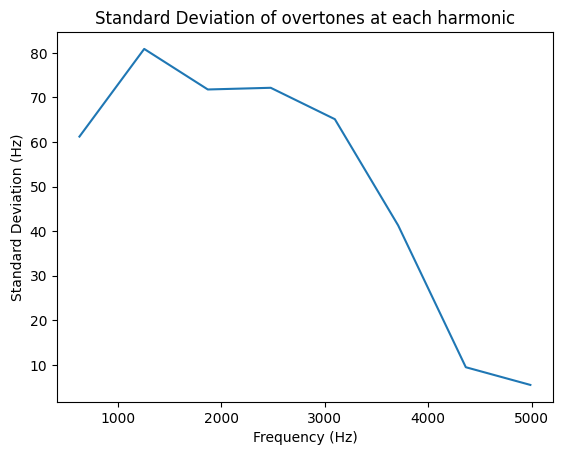

In [30]:
freq_means = []
freq_stdevs = []
freq_counts = []
for group in grouped_frequencies:
    freq_means.append(int(np.mean(group)))
    freq_stdevs.append(np.std(group))
    freq_counts.append(len(group))
plt.plot(freq_means,freq_stdevs)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Standard Deviation (Hz)")
plt.title("Standard Deviation of overtones at each harmonic")
plt.show()

Observation from *Standard Deviation of overtones at each harmonic*:
- The standard deviation decreases as the harmonic increases. Is this because of higher pitch or a higher overtone, or both? We would need to study another trumpet pitch to find out.

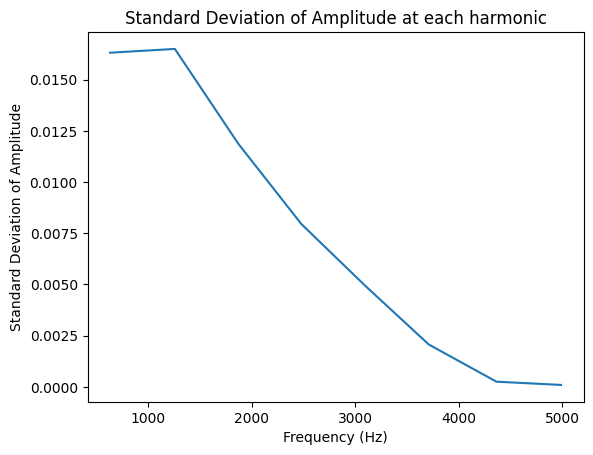

In [31]:
amplitude_means = []
amplitude_stdevs = []
amplitude_counts = []
for group in grouped_amplitudes:
    amplitude_means.append(np.mean(group))
    amplitude_stdevs.append(np.std(group))
    amplitude_counts.append(len(group))
plt.plot(freq_means,amplitude_stdevs)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Standard Deviation of Amplitude")
plt.title("Standard Deviation of Amplitude at each harmonic")
plt.show()

Observation from *Standard Deviation of Amplitude at each harmonic*:
- Standard deviation of amplitude decreases as the harmonic increases. This makes sense because the first few harmonics have a large outlier (the center pitch) which would significantly increase the standard deviation.

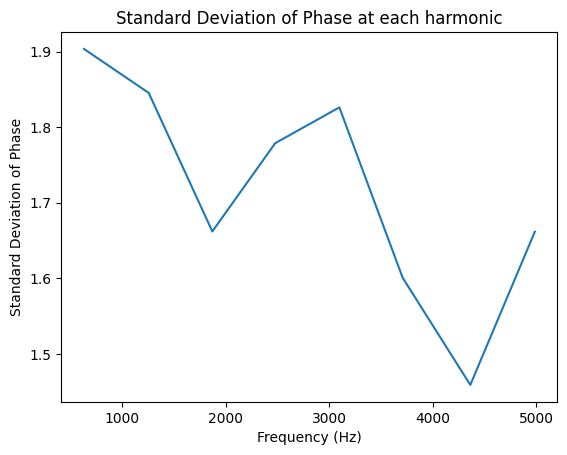

In [32]:
phase_means = []
phase_stdevs = []
phase_counts = []
for group in grouped_phases:
    phase_means.append(np.mean(group))
    phase_stdevs.append(np.std(group))
    phase_counts.append(len(group))
plt.plot(freq_means,phase_stdevs)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Standard Deviation of Phase")
plt.title("Standard Deviation of Phase at each harmonic")
plt.show()

Observation from *Standard Deviation of Phase at each harmonic*:
- The trend still seems like it's going down however the slope is not significant compared to the overall movement over the harmonics. It seems unlikely there is a strong causal relationship here.

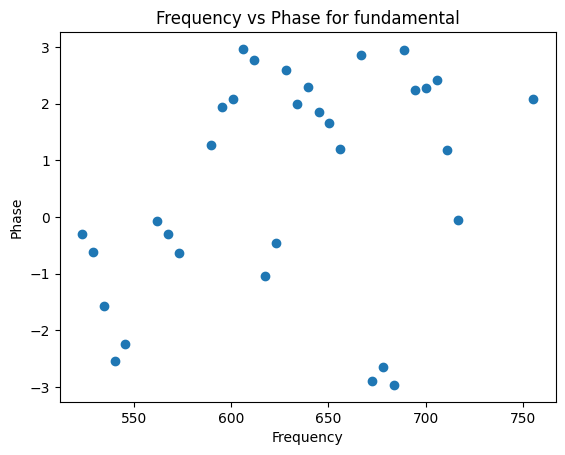

In [33]:
group_freq_0, group_phase_0 = grouped_frequencies[0], grouped_phases[0]
len(group_freq_0), len(group_phase_0)
plt.scatter(group_freq_0, group_phase_0)
plt.xlabel("Frequency")
plt.ylabel("Phase")
plt.title("Frequency vs Phase for fundamental")
plt.show()#observation - phase seem fairly randomly distributed within one harmonic

Observation from *Frequency vs Phase for fundamental*:
- There seems to be no pattern here. It is therefore reasonably safe to assume that for each harmonic, the distribution of phase is random inside the range [-3, 3].

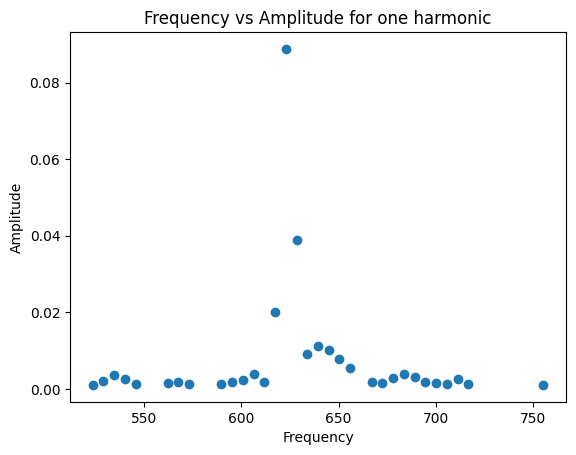

In [34]:
group_freq_0, group_amp_0  = grouped_frequencies[0], grouped_amplitudes[0]
plt.scatter(group_freq_0, group_amp_0)
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title("Frequency vs Amplitude for one harmonic")
plt.show();

Observation from *Frequency vs Amplitude for one harmonic*:
- The amplitude is higher near the true frequency of the harmonic (as we can see in the FFT plots above).
- The peak is so narrow and steep. In order to mimic this in a synthetic note we can probably just assign a large amplitude to the harmonic, then all the surrounding pitches can be the same amplitude.

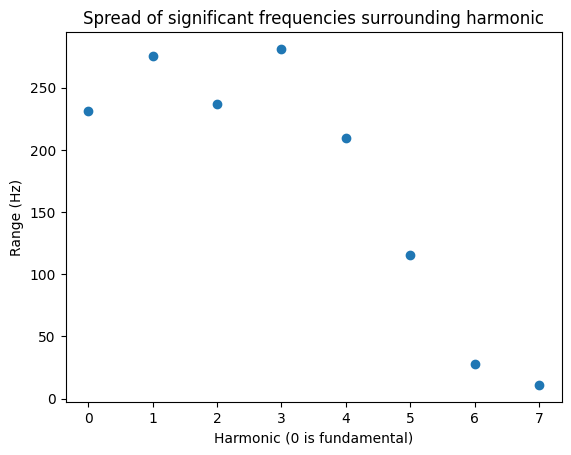

In [35]:
frequency_spreads = [max(freqs)-min(freqs) for freqs in grouped_frequencies] #get the range for each harmonics frequencies
plt.scatter([h for h in range(8)], frequency_spreads)
plt.xlabel("Harmonic (0 is fundamental)")
plt.ylabel("Range (Hz)")
plt.title("Spread of significant frequencies surrounding harmonic");

Observation from *Spread of significant frequencies surrounding harmonic*:
- The range (max-min) of frequencies surrounding each harmonic seems to decrease as the partial increases. This makes sense since the standard deviation has the same trend.
- We will arbitrarily generalize the below frequency spreads.

In [36]:
frequency_spreads = [250, 250, 250, 250, 200, 100, 50, 25]

## Fully synthetic note creation

Now that we have studied the data of a real trumpet note we will try to generalize some of the things we learned in order to create a fake trumpet note.

We will create one final function to calculate the harmonic series (up to the 7th partial) given some fundamental frequency. This will make it a little bit easier to create our synthetic note.

Here are the steps we will take:
1. Generate the harmonic series based off a chosen fundamental frequency. We know the hamornic series is key for reproducing the trumpet sound.
2. Generate 10 lower frequencies on either side of each harmonic. The spread of the frequencies will be based on the one note we wave studied. We will use even spacing and give each frequency an amplitude of 0.002 for simplicity. At this point we can see the smaller frequencies surrounding each harmonic but we really don't understand what their contribution is to the sound of the note.
3. For each frequency, we will randomly choose the phase on the range [-3, 3]. This is somewhat arbitrary as well. We know that the recorded note has approximately this range of phases and they seem random. However, we don't know what the impact of this is on the sound.
4. Finally we will sum together all the signals and see what it sounds like. 
5. For good measure we can plot the Fourier Transform and make sure it looks as expected.

In [37]:
def get_harmonic_series(fundamental_freq_hz: float) -> np.ndarray:
    """
    Calculate the first 7 harmonics of the provided pitch.

    Parameters:
    ----------
    fundamental_freq_hz : float
        The fundamental frequency in Hertz for which the overtones are to be calculated.

    Returns:
    -------
    np.ndarray
        An array of frequencies representing the overtones of the given fundamental frequency. The fundamental is included as the first element of the array.
    """
    factors = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])
    return fundamental_freq_hz * factors

In [38]:
harmonic_amplitudes = []
for amps in grouped_amplitudes:
    harmonic_amplitudes.append(max(amps))
harmonic_amplitudes

[0.08878069370985031,
 0.09560765326023102,
 0.05766507610678673,
 0.04233686253428459,
 0.02387140691280365,
 0.00741793867200613,
 0.0018993434496223927,
 0.0012590348487719893]

In [39]:
non_harmonic_amplitude = 0.002

In [40]:
harmonic_series = get_harmonic_series(623)
time_seconds = np.linspace(0, 1, sr) #1 second of audio at sr of 16000
summed_signal = np.zeros(len(time_seconds))
for i in range(len(harmonic_series)):
    base_freq = harmonic_series[i] #this is the frequency of the base note of whatever harmonic we are on
    base_amplitude = harmonic_amplitudes[i]
    freq_spread = frequency_spreads[i]
    half_spread = freq_spread/2
    non_harmonic_frequencies = list(np.linspace(base_freq-half_spread, base_freq, 10, endpoint=False))
    non_harmonic_frequencies.extend(list(np.linspace(base_freq+half_spread, base_freq, 10, endpoint=False)))

    #create and add harmonic signal
    summed_signal += reconstruct_frequency(base_freq, time_seconds, base_amplitude, np.random.uniform(-3, 3))

    #create and add non-harmonic signals
    for non_harmonic_freq in non_harmonic_frequencies:
        summed_signal += reconstruct_frequency(non_harmonic_freq, time_seconds, non_harmonic_amplitude, np.random.uniform(-3, 3))

In [41]:
ipd.Audio(data=summed_signal, rate=sr)#does not sound as expected!

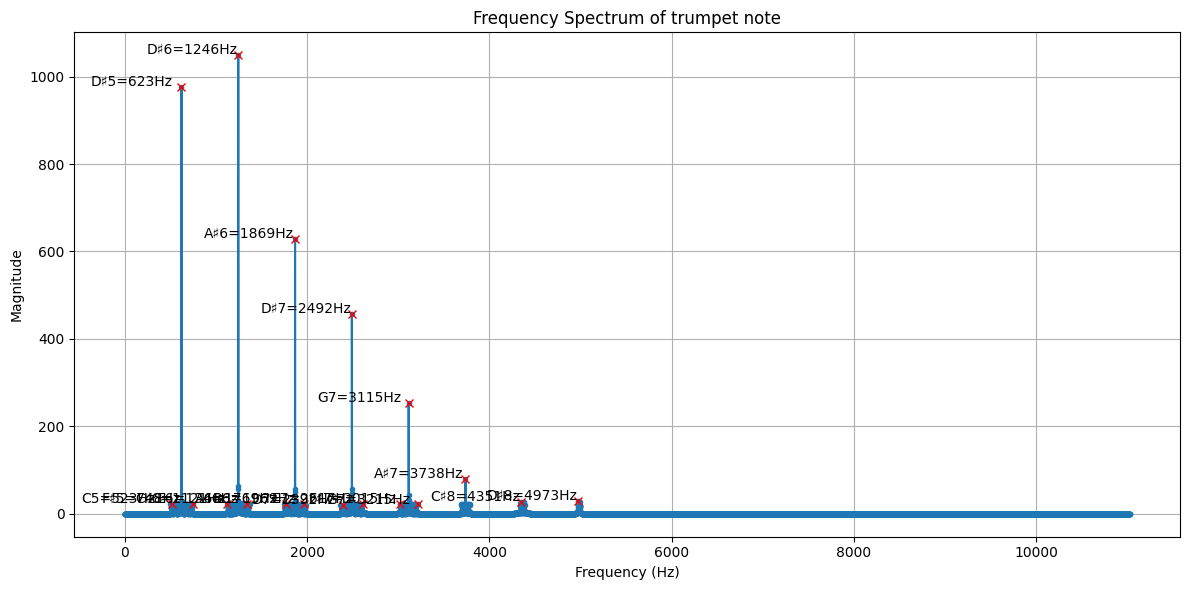

In [42]:
fig, ax, peak_frequencies = plot_frequency_spectrum(summed_signal, sr, return_peaks=True) #looks as expected!

As you can hear, this really does not sound that much like a trumpet. It has some of the elements but clearly our simplistic way of creating the note does not capture the complexity of a real musical instrument. 

# Conclusion


Through study and deconstruction of a single note we have seen the harmonic series and shows how important it is to the sound of a trumpet. We have practiced the basics of signal processing including Fourier Transform how we can reproduce or subtract frequencies from a signal. Finally, we have studied the relationships between the harmonic overtones and frequency, phase, and amplitude. We tried (and mostly failed) to create a synthetic trumpet note.


Finally, here are some follow up tasks that could be pursued to take this exercise further:
- Study other trumpet pitches to see which of the relationships in frequency, phase, and amplitude hold up.
- Study other trumpet recordings to see which of the relationships in frequency, phase, and amplitude hold up.
- Take these learnings and create a more sophisticated algorithm for creation of trumpet notes.